<a href="https://colab.research.google.com/github/Maguifall/MAGATTE/blob/main/MLSS-DNN-DAY1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel and distributed Deep Learning, Part I
### MLSS, June 24 2025, Mbour, Senegal

## Author: Marieme Ngom, Argonne National Laboratory
(combining and adapting materials/discussion evolved over time by ***Sam Foreman, Huihuo Zheng***, Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, Tanwi Mallick, and Venkat Vishwanath)
## Outline
1. ***Day 1***
    - Evolution of computig systems
    - Parallel computing
    - Introduction to Deep Learning
    - Parallel computing in AI


2. Day 2
    - Brief Introduction to LLMs
    - Hands-on LLM training

***Special thanks to T.A. Egor Shulgin and to Bamba Diouf for doing the AWS porting***

## Clone repo
https://github.com/mngom2/DNNMLSS/tree/main

Then:
1. Sign in at [Google Collab](https://colab.research.google.com/)
2. Go to ***File->Open a notebook->GitHub->Enter above URL then select MLSS-DNN-DAY1.ipynb***

Or on AWS (follow Bamba's instructions)

# Parallel computing
**Parallel computing** refers to the process of breaking down larger problems into smaller, independent, often similar parts that can be executed simultaneously by multiple processors communicating via network or shared memory, the results of which are combined upon completion as part of an overall algorithm.

## $\pi$ example
We can calculate the value of $\pi$ using a MPI parallelized version of the Monte Carlo method. The basic idea is to estimate $\pi$ by randomly sampling points within a square and determining how many fall inside a circle inscribed within that square.

![PI](https://www.101computing.net/wp/wp-content/uploads/estimating-pi-monte-carlo-method.png)

The ratio between the area of the circle and the square is

$\frac{N_\text{in}}{N_\text{total}} = \frac{\pi r^2}{4r^2} = \frac{\pi}{4}$

Therefore, we can calculate $\pi$ using
$\pi = \frac{4N_\text{in}}{N_\text{total}} $

Pi = 3.16
Time: 83.92170000076294


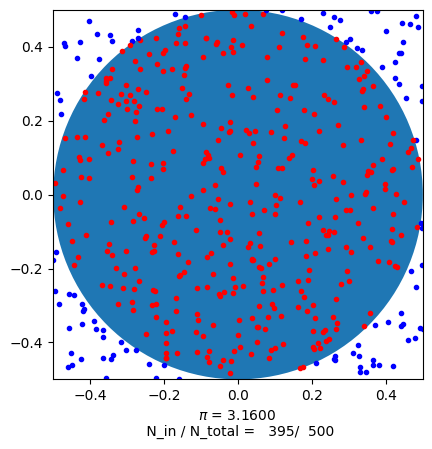

In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
import time
fig, ax = plt.subplots()
#ax = fig.add_subplot(111)
circle = plt.Circle(( 0. , 0. ), 0.5 )
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
ax.add_patch(circle)
ax.set_aspect('equal')
N = 500
Nin = 0
t0 = time.time()
for i in range(1, N+1):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
        plt.plot([x], [y], 'o', color='r', markersize=3)
    else:
        plt.plot([x], [y], 'o', color='b', markersize=3)
    display(fig)
    plt.xlabel("$\pi$ = %3.4f \n N_in / N_total = %5d/%5d" %(Nin*4.0/i, Nin, i))
    clear_output(wait=True)

res = np.array(Nin, dtype='d')
t1 = time.time()
print(f"Pi = {res/float(N/4.0)}")
print("Time: %s" %(t1 - t0))

### MPI example
```python
from mpi4py import MPI
import numpy as np
import random
import time
comm = MPI.COMM_WORLD

N = 5000000
Nin = 0
t0 = time.time()
for i in range(comm.rank, N, comm.size):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
res = np.array(Nin, dtype='d')
res_tot = np.array(Nin, dtype='d')
comm.Allreduce(res, res_tot, op=MPI.SUM)
t1 = time.time()
if comm.rank==0:
    print(res_tot/float(N/4.0))
    print("Time: %s" %(t1 - t0))
```

In [ ]:
# !pip install wget

In [ ]:
# import wget

# # Download a file
# url = "https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/mpi_pi.py"
# filename = wget.download(url)
# print(f"Downloaded: {filename}")

# # With custom filename
# # wget.download(url, "custom_name.txt")

You need mpi4py installed, on macOS, do:
```brew install mpich
pip install mpi4py```

In [ ]:
! mpirun -np 1 python3.7 mpi_pi.py

Number of processes: 1
Pi = 3.1414984
Time: 6.562232


In [ ]:
! mpirun -np 2 python3.7 mpi_pi.py

Number of processes: 2
Pi = 3.1411256
Time: 3.301942


In [ ]:
! mpirun -np 4 python3.7 mpi_pi.py

Number of processes: 4
Pi = 3.1408808
Time: 1.971712


# Introduction to Deep Neural Networks

This is a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/mngom2/DNNMLSS/blob/main/images/mnist_task.png?raw=1"  align="left"/>


In [ ]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [ ]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [ ]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [ ]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

Let's take a closer look. Here are the first 10 training digits:

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

We consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/mngom2/DNNMLSS/blob/main/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b).
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd). For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A ***learning rate*** which controls how far we move during each step.

In [ ]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [ ]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.





In [ ]:
batch_size = 128
# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [ ]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [ ]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.

In [ ]:
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [ ]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [ ]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')

    # Create all subplots at once
    fig, axes = plt.subplots(1, maxtoshow, figsize=(maxtoshow, 1))
    if maxtoshow == 1:
        axes = [axes]  # Handle single subplot case

    ii = 0
    for i in range(batch[0].shape[0]):
        if ii >= maxtoshow:
            break
        if errors[i]:
            axes[ii].axis('off')
            axes[ii].imshow(batch[0][i,0,:,:], cmap="gray")
            axes[ii].set_title("%d (%d)" % (rounded[i], batch[1][i]))
            ii += 1

Here are the first 10 images from the test data that this small model classified to a wrong class:

In [ ]:
show_failures(linear_model, test_dataloader)

# Multilayer Model

Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/mngom2/DNNMLSS/blob/main/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/mngom2/DNNMLSS/blob/main/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/mngom2/DNNMLSS/blob/main/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/mngom2/DNNMLSS/blob/main/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/mngom2/DNNMLSS/blob/main/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [ ]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [ ]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [ ]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [ ]:
show_failures(nonlinear_model, test_dataloader)

# Training on the GPU

In [ ]:
#device = torch.device(
#    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# targetting the first GPU cuba:0
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [ ]:
def evaluate_device(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model.to(device)(X.to(device))
            loss += loss_fn(pred, y.to(device)).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [ ]:
def train_one_epoch_device(dataloader, model, loss_fn, optimizer,device):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [ ]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch_device(train_dataloader, nonlinear_model, loss_fn, optimizer,device) # modified this to use the nonlinear_model instead

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate_device(train_dataloader, nonlinear_model, loss_fn,device)  # modified this to use the  evaluate_device function and the nonlinear_model instead
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate_device(val_dataloader, nonlinear_model, loss_fn,device) # modified this to use the  evaluate_device function and the nonlinear_model instead
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

## Training on a single device

### Single GPU
![x0](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-1.png?raw=1)
![x1](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-17.png?raw=1)
![x2](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-16.png?raw=1)

### Recipes for efficient training on a single GPU

***Batch size choice*** *It is recommended to use batch sizes and input/output neuron counts that are of size 2^N. Tensor Core Requirements define the multiplier based on the dtype and the hardware. For instance, for fp16 data type a multiple of 8 is recommended, unless it’s an A100 GPU, in which case use multiples of 64.*

***Gradient accumulatiom*** *The gradient accumulation method aims to calculate gradients in smaller increments instead of computing them for the entire batch at once. This approach involves iteratively calculating gradients in smaller batches by performing forward and backward passes through the model and accumulating the gradients during the process. Once a sufficient number of gradients have been accumulated, the model’s optimization step is executed. By employing gradient accumulation, it becomes possible to increase the effective batch size beyond the limitations imposed by the GPU’s memory capacity. However, it is important to note that the additional forward and backward passes introduced by gradient accumulation can slow down the training process.*



### More in [Methods and tools for efficient training on a single GPU](https://huggingface.co/docs/transformers/v4.46.0/perf_train_gpu_one)


# Parallel Computing in AI


Distributed training is the process of training models across multiple GPUs or other accelerators, with the goal of speeding up the training process and enabling the training of larger models on larger datasets.

There are two ways of parallelization in distributed training.
* ***Data parallelism***:
    * Each worker (GPU) has a complete set of model
    * different workers work on different subsets of data.
* *Model parallelism*
    * The model is split into different parts and stored on different workers
    * Different workers work on computation involved in different parts of the model
![PI](https://github.com/mngom2/DNNMLSS/blob/main/images/parallel_computing.png?raw=1)

## Scaling goal:
1. Minimize cost i.e. amount of time spent training
2. Maximize performance i.e model quality metrics, throughput/efficiency metrics (images/seconds, GPU/CPU utilization percentages, flops efficiency)

## Training on multiple GPUs: Data Parallelism
### Nomenclature:
- N = number of GPUs = WORLD_SIZE
- Each GPU is assigned a rank from 0 to WORLD_SIZE-1
- A worker = a GPU here
![mgpus](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-15.png?raw=1)
*Each GPU receives unique data at each step*
### Data Parallel: Forward Pass
![forward](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-14.png?raw=1)
*Average gradients across all GPUs*
### Data Parallel: Backward Pass
![backward](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-13.png?raw=1)
*Send global updates back to each GPU*
### Data Parallel: Full Setup
![full](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-12.png?raw=1)
*See: [PyTorch / Distributed Data Parallel](https://docs.pytorch.org/tutorials/intermediate/ddp_tutorial.html)*
### Data Parallel: Training
- Each GPU:
    - has identical copy of model
    - works on a unique subset of data
- Easy to get started with
    - [saforeman2/ezpz](https://github.com/saforem2/ezpz)
    - [PyTorch/DDP](https://docs.pytorch.org/docs/stable/notes/ddp.html)
    - [HF/Accelerate](https://huggingface.co/docs/transformers/accelerate)
    - [Microsoft/DeepSpeed](https://www.deepspeed.ai)
- Requires ***global*** communication
    - every rank must participate (collective communication)

## Communication
- Need mechanism(s) for communicating across GPUs:
    - [mpi4py](https://mpi4py.readthedocs.io/en/stable/tutorial.html)
    - [torch.distributed](https://docs.pytorch.org/docs/stable/distributed.html)
- Collective communication:
    - [Nvidia Collective Communications Library (NCCL)](https://developer.nvidia.com/nccl)
    - [Intel oneAPI Collective Communications](https://www.intel.com/content/www/us/en/developer/tools/oneapi/oneccl.html#gs.n9y302)
***Timeouts*** Collective operations have to be called for each rank to form a complete collective operation.
Failure to do so will result in other ranks waiting indefinitely
### AllReduce
![allreduce](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-11.png?raw=1)

### Broadcast
![broadcast](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-9.png?raw=1)

## Dealing with Data
- At each training step, we want to ensure that each worker receives unique data
- This can be done in one of two ways:
    1. Manually partition data (ahead of time)
        - Assign unique subsets to each worker
        - Each worker can only see their local portion of the data
        - Most common approach
    2. From each worker, randomly select a mini-batch
        - Each worker can see the full dataset
        - ⚠️ When randomly selecting, it is important that each worker uses different seeds to ensure they receive unique data

## Broadcast Initial State
- At the start of training (or when loading from a checkpoint), we want all of our workers to be initialized consistently
    - Broadcast the model and optimizer states from rank() == 0 worker
![bcast](https://github.com/mngom2/DNNMLSS/blob/main/images/mermaid-figure-6.png?raw=1)

## Data parallel training: recap
![recap](https://github.com/mngom2/DNNMLSS/blob/main/images/avgGrads.svg?raw=1)

## Why distributed training?
- N workers each processing unique batch (micro batch size) of data:
    - (micro_batch_size = 1)× $N_{GPUs}$ → ***global_batch_size = N***
- Improved gradient estimators
    - Smooth loss landscape
    - Less iterations needed for same number of epochs
        - common to scale learning rate lr *= sqrt(N)
        
![speedup](https://github.com/mngom2/DNNMLSS/blob/main/images/speedup.png?raw=1)

## Best Practices
**Keeping things in Sync**
***Computation stalls during communication !!***

Keeping the communication to computation ratio small is important for effective scaling.

- Use parallel IO whenever possible
    - Feed each rank from different files
    - Use MPI IO to have each rank read its own batch from a file
    - Use several ranks to read data, MPI to scatter to remaining ranks
        - Most practical in big at-scale training
- Take advantage of data storage
    - Use striping
    - Use the right optimizations for your HPC cluster.
    - Preload data when possible
    - Offloading to a GPU frees CPU cycles for loading the next batch of data
        - minimize IO latency this way

## Going Beyond Data Parallelism
- Useful when model fits on single GPU:
    - ultimately limited by GPU memory
    - model performance limited by size
- ⚠️ When model does not fit on a single GPU:
    - Offloading (can only get you so far…):
        - DeepSpeed + ZeRO
        - PyTorch + FSDP
- Otherwise, resort to [model parallelism strategies](https://samforeman.me/talks/ai-for-science-2024/slides#/additional-parallelism-strategies)

**Tomorrow, we will give a high level introduction to LLMs and train one across multiple GPUs.**